# -- ARTS multi-FOV 2DVAR surface retrievals --

In [1]:
#  David Duncan, Chalmers University, Feb 2019

#  this script uses ARTS OEM to experiment with retrieval of a synthetic scene. 
#    the goal here is to probe the spatial resolution of geophysical parameter 
#    that may be retrievable with such a sensor, focused on AMSR2 and surface params

# this setup, in steps/words:
### - define an antenna response that is frequency dependent, gaussian, symmetric
### - define sensor position and line of sight for each scan at middle of scan
### - define an angular grid (zenith & azimuth) for each scan that encompasses npix
### - sensor angles are all 'absolute' whereas the angular grid and antenna response 
###    are all relative to the central bore sight of the scan
### - a lat/lon grid is also defined that must encompass all observation points simulated
### - the same angular grid and simulation setup is assumed/copied for all nscans, and 
###    mblock_dlos_grid allows all simulations to be run at the same time

### *** this setup outputs simulates TBs for chosen channels of AMSR2
###    with antenna patterns taken into account and decoupled from any retrieval grid, with
###    pencil beam calculations sampling the antenna pattern according to the angular grid
###    defined

### a priori covariances are defined in terms of standard deviations and decorrelation lengths
###  and observation error covariances are frequency dependent

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from cmocean import cm as cmo
import time
startt = time.time()

# Define # of vars, channels, size of retrieval, and covariance assumptions

In [3]:
# frequency subset, defined by AMSR2 frequency indices: 0=6.9GHz, 1=7.3, 2=10.6, 3=18.7, 4=23.8, 5=36.5, 6=89
#fsub  = np.array([0, 1, 2, 3, 5]) # choose which frequencies to run (runs both polarisations--v/h)
fsub = np.array([0,1,2,3,4,5,6])
sfsub= str("frs")+"".join(map(str,fsub)) #  string of frequencies (for plot outputs)

deco_sst = 1.5  # SST decorrelation length of a priori [deg] -- set to near-zero if wanting none
deco_wsp = 1.8  # wind decorrelation length of a priori [deg] 
pv = 'v5_fn_r1_'+sfsub # plot version (end of plots' filenames)
sv = True      # whether or not to save output plots


nrvar    = 2     # number of retrieval variables, 1 will be SST only, 2 for SST+windspeed

npix     =  35   # pixels across each scan considered
nscans   =  17   # consecutive scans considered
angfac   =   4   # angular samples per degree or between pix -- should be min ~10 (but depends on freqs used)
sx_sst   = 1.9   # a priori std deviation for SST
sx_wsp   = 3.3   # a priori std deviation for wind speed (if nrvar > 1)
xcorr    = 0.0   # cross correlation between SST and wind speed -- not currently used (keep sparse matrix for speed)

# these should likely remain fixed:
nfac   = 1.0  # multiply sense noise (nedt) by this factor
nedt   = np.array([0.34, 0.43, 0.7, 0.7, 0.6, 0.7, 1.2])[fsub] # from published NEdT values
npol     =  2    # number of polarizations considered (2=V/H both, 1=intensity only)

#  note: for speed, the angular grid is the biggest limiting factor, so if using low frequencies only
#    then angfac<~5 is quite justified

In [4]:
# Define lat/lon grid that observation points and angular grid lie within
lat0     = -3.0  # center of grid in lat, lon 
lon0     = 4.0
nlat, nlon = 80, 100        # number of lat and lon divisions
latwid, lonwid = 2.0, 2.5  # actual grid widths are double these

# retrieval grid resolution (set down below)
r_resa, r_reso = 0.1, 0.1

resa = 2*latwid/nlat  #lat grid resolution
reso = 2*lonwid/nlon  #lon grid resolution
print('Grid resolution is ', resa, reso)
 
la_grid = lat0 + np.arange(-latwid, latwid+resa, resa)
lo_grid = lon0 + np.arange(-lonwid, lonwid+reso, reso)
# keep these (non-ARTS vars) for sake of plotting at the end!
 
#print('corners of la_grid: ',la_grid)
#print('midpoints of la_grid (ARTS ws grid): ',latgrid[0:nlat]+np.diff(la_grid)*.5)

Grid resolution is  0.05 0.05


# Set up ARTS environment

In [5]:

%env ARTS_INCLUDE_PATH=/home/dudavid/arts/controlfiles/
%env ARTS_BUILD_PATH=/home/dudavid/arts/build/
%env ARTS_DATA_PATH=/home/dudavid/arts/arts-xml/ 

%matplotlib inline
#from h5py import File
from scipy.spatial.distance import pdist      # calculate pair-wise distances (euclidean)
from scipy.spatial.distance import squareform # convert from reduced matrix to square

from typhon.arts.workspace import Workspace, arts_agenda
ws = Workspace(verbosity=0)
ws.execute_controlfile("general/general.arts")
ws.execute_controlfile("general/continua.arts")
ws.execute_controlfile("general/agendas.arts")
ws.execute_controlfile("general/planet_earth.arts")

from typhon.arts.workspace.variables import *

# set various ARTS agendas:
ws.Copy( ws.abs_xsec_agenda, ws.abs_xsec_agenda__noCIA )
ws.Copy( ws.iy_main_agenda, ws.iy_main_agenda__Emission )
ws.Copy( ws.iy_space_agenda, ws.iy_space_agenda__CosmicBackground )
ws.Copy( ws.propmat_clearsky_agenda, ws.propmat_clearsky_agenda__OnTheFly )
ws.Copy( ws.ppath_agenda, ws.ppath_agenda__FollowSensorLosPath )
ws.Copy( ws.ppath_step_agenda, ws.ppath_step_agenda__GeometricPath )
@arts_agenda
def geo_pos_agendaPY(ws):
    ws.geo_posEndOfPpath()
ws.Copy( ws.geo_pos_agenda, geo_pos_agendaPY)  ## new one, set by patrick in his cfile

# define absorbing species and sensor (here using metmm library, used again below)
ws.abs_speciesSet(species=["H2O-PWR98","O2-PWR93","N2-SelfContStandardType"])#,"liquidcloud-ELL07"])
ws.abs_lines_per_speciesSetEmpty()

ws.stokes_dim = npol     # to get V and H pol set to 2
ws.iy_unit = "PlanckBT"  # equivalent: ws.StringSet( iy_unit, "PlanckBT" )

env: ARTS_INCLUDE_PATH=/home/dudavid/arts/controlfiles/
env: ARTS_BUILD_PATH=/home/dudavid/arts/build/
env: ARTS_DATA_PATH=/home/dudavid/arts/arts-xml/
Loading ARTS API from: /home/dudavid/arts/build/src/libarts_api.so


In [6]:
# set up atmosphere and surface variables:
ws.atmosphere_dim = 3  # 3D atmosphere
p = np.array([1015.,950.,800.])*100.0 #keep it simple, otherwise slower fwd model -- IGNORES LOTS OF WV!!!
#p = np.array([1015.,975.,950.,925.,900.,850.,800.,750.,700.,650.,600.,550.,500.,400.,300.,200.,100.])*100.0
ws.p_grid = p[:] 
ws.AtmRawRead( basename = "planets/Earth/Fascod/tropical/tropical") #tropical atmosphere assumed
ws.AtmosphereSet3D()

ws.lat_grid = np.copy( la_grid[0:nlat] + np.diff(la_grid)*.5 ) # to avoid mismatch between ARTS and pcolormesh
ws.lon_grid = np.copy( lo_grid[0:nlon] + np.diff(lo_grid)*.5 ) #  i.e. getting lat/lon midpoints of boxes

ws.AtmFieldsCalcExpand1D()  # set to given p_grid or z_grid

#ws.vmr_field.value[0,:,:,:] *= 0.50 # try decreasing water vapor by X

# if using coarse atmosphere but wanting accurate ray tracing:
ws.ppath_lmax = 350.0  # set maximum distance between points when computing absorption along path

# Define synthetic ocean surface scene, set in ARTS

s_data shape:  (4, 80, 100)


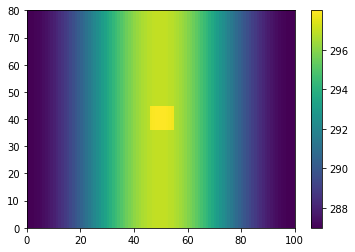

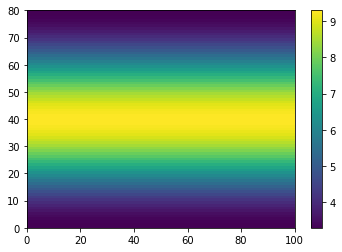

In [7]:
# Surface properties -- define ocean surface for simulations

nala, nalo = np.size(ws.lat_grid.value), np.size(ws.lon_grid.value) # size of ARTS lat/lon grid
s_names = ["Water skin temperature","Wind speed","Wind direction","Salinity"]
s_data = np.zeros([len(s_names), nala, nalo])  ## page/row/col
print('s_data shape: ',s_data.shape)

tmean                   = 292.0 # sst mean
wsp                     = 6.3   # 10m wind speed
s_data[0,:,:] = tmean
#s_data[0,int(nlat/2)-1:int(nlat/2)+2,int(nlon/2)-1:int(nlon/2)+2] += 6
#s_data[0,:,::8] += 0.9  ## czechers
s_data[0,int(nlat/2)-4:int(nlat/2)+5,int(nlon/2)-4:int(nlon/2)+5] += 1.0
s_data[0,:,:] += 5.0 * np.cos( np.tile(np.linspace(-np.pi,np.pi,nalo),[nala,1])) #.transpose() 
#s_data[0,:,:] += np.random.normal(0, 1, [nala,nalo])
#s_data[0,int(nlat/3)-0:int(nlat/3)+3,:] += 2.0
#s_data[0,int(nlat*2/3)-3:int(nlat*2/3)+0,:] -= 3.0
#s_data[0,1::4,::4] -= 2.9  ## czechers
#s_data[0,::2,1::3] -= 1.9
#s_data[0,::2,2::3] += 0.9
#s_data[0,:,:] += np.tile(np.arange(0,nala),[nalo,1])
s_data[1,:,:] = wsp
#s_data[1,:,:] += np.random.normal(1.2, 1.9, [nala,nalo])
#s_data[1,:,:] += 0.35 * np.tile(np.arange(0,nala),[nalo,1]).transpose() 
s_data[1,:,:] += 3.0 * np.cos( np.tile(np.linspace(-np.pi,np.pi,nala),[nalo,1])).transpose() 
s_data[2,:,:] = 90 # token wind direction value
s_data[3,:,:] = 0.034 # token salinity value

# write these to ARTS variables 
ws.Copy(ws.surface_props_names, s_names)
ws.Copy(ws.surface_props_data, s_data)
ws.MatrixSetConstant(ws.z_surface, nala, nalo, 0.0) # explicitly set the surface to 0m altitude

plt.pcolor(s_data[0,:,:]) # quick look for SST
plt.colorbar()
plt.show()
plt.pcolor(s_data[1,:,:]) # quick look for wsp
plt.colorbar()
plt.show()

# Define antenna pattern

In [8]:
# Set and calculate some basic variables for antenna and scanning

### All will be replaced or superseded if using L1R data as input
 
zsat   = 699.7e3      # Satellite altitude [m] -- can read this in later
vsat   = 6.76e3       # Satellite velocity [m/s]
dt     = 2.6e-3       # Integration time [s] -- 2.6ms for low freqs, 1.3ms for 89GHz
rpm    = 40           # Rotations per minute -- same for AMSR-E and AMSR2
 
# nautical mile constant?  1852m = 1nmi
m2deg  = 1/(60*1852)                          # Conversion from m to latitude
dang   = dt * 360 * rpm / 60                  # Angular distance between samples
dlat   = m2deg * vsat * 60 / rpm              # Latitude distance between scans
print(dang,dlat)

0.624 0.09125269978401726


In [9]:

width  = 1.8           # Max half-width of antenna simulated (if HPBW is 1.8deg, width=2 covers 2x the HPBW)
resol  = 0.01          # angular resolution (same in zenith/azimuth)
# note: for a given angular resolution (might vary), width=2 yields 99.96% of total power @6GHz 
#   compared to width=20 and 99.99999% @10GHz, width=1.5 yields 99.0 and 99.994 @ 6,10
#resol, width = dang/(angfac*5), awidth # set here instead of calling func
print('angular resolution of response grid [deg]: ',resol)

adata = [[ 6.925e9 ,  1.80],   # AMSR2 center frequency and beamwidth (deg)
         [ 7.300e9 ,  1.80],   # assumed the same for V/H polarizations
         [ 10.65e9 ,  1.20],
         [ 18.70e9 ,  0.65],
         [ 23.80e9 ,  0.75],
         [ 36.50e9 ,  0.35],
         [ 89.00e9 ,  0.15]] 

adata = np.array(adata, order="C").transpose()[:,fsub] # choose selected frequencies (set above)

# define zenith, azimuth grid on the ground (relative to bore sight) -- assumed to be square, 2xWidth wide
x  = np.arange( -width, width+resol, resol )  #this gives angular antenna response points in za,aa
x2 = x**2   # since assumed origin is 0, do squaring here 
nf, nx = len(adata[0,:]), np.size(x)   # num frequencies, size of antenna grid

csub = np.sort(np.append(fsub*2,fsub*2+1))
ch_str = np.array(['6V','6H','7V','7H','10V','10H','18V','18H',
                   '23V','23H','36V','36H','89V','89H'])[csub] 
#print(ch_str)

from typhon.arts.griddedfield import GriddedField4
gf4 = GriddedField4()   # ARTS variable type, found in typhon
gf4.name = 'AMSR2 antenna response'
gf4.gridnames =  [ 'Polarisation', 'Frequency', 'Zenith angle', 'Azimuth angle' ]
###  note: za & aa are equally spaced, and we're treating V/H as having identical responses
if npol==2: gsp="1" 
else: gsp="0"
gf4.grids     = [ [gsp], adata[0,:], x, x ]
gf4.dataname  = 'Response'
gf4.data      = np.zeros([ 1, nf, nx, nx ], order="C")
print('size of antenna_reponse grid: ',gf4.data.shape)

for i in range(nf):
    si = adata[1,i] / (2*np.sqrt(2*np.log(2)))  # calculate standard deviation first, based on HPBW
    gf4.data[0,i,:,:] = np.exp( - np.tile(x2,[nx,1])/si**2 - np.tile(x2,[nx,1]).transpose()/ si**2 )


# frequency grid of simulation is defined according to sensor setup above (may change with use of metmm)
f_grid = np.copy(gf4.grids[1])  # array with each frequency (not channel)

ws.f_grid.value = f_grid
print('f_grid: ',ws.f_grid.value)
 
#plt.pcolormesh(gf4.data[0,0,:,:])# to plot antenna pattern of one freq
#plt.show()

angular resolution of response grid [deg]:  0.01
size of antenna_reponse grid:  (1, 7, 361, 361)
f_grid:  [6.925e+09 7.300e+09 1.065e+10 1.870e+10 2.380e+10 3.650e+10 8.900e+10]


# Define bore sights for one scan, angular grid for fwd model

In [10]:
# Determine bore-sight angles to use for one scan 
 
# psteps defines the pixels across one scan
psteps   = np.arange(-(npix-1)/2, (npix-1)/2 +1, 1)  #  if npix is odd then middle boresight is in the middle
# ssteps defines position of spacecraft for each scan, evenly distributed around the middle scan
ssteps   = np.arange(-(nscans-1)/2, (nscans-1)/2 +1, 1) 

#  center line of sight... defined as AMSR2 EIA and 0 azimuth angle
los0    = [ 180-47.5, 0 ]  # 47.5 is off-nadir angle of AMSR2, 180 for looking straight down

# bsights defines the bore sight zenith and azimuth angles across the scan 
##-- just for one scan, assumed to be same / repeated for all scans
bsights = np.array([ np.repeat(los0[0],npix), los0[1]+dang*psteps ]).transpose()  # size: [npix,2]
print('bsights:',(bsights[:,1]))

bsights: [-10.608  -9.984  -9.36   -8.736  -8.112  -7.488  -6.864  -6.24   -5.616
  -4.992  -4.368  -3.744  -3.12   -2.496  -1.872  -1.248  -0.624   0.
   0.624   1.248   1.872   2.496   3.12    3.744   4.368   4.992   5.616
   6.24    6.864   7.488   8.112   8.736   9.36    9.984  10.608]


In [11]:
# Define angular grid for pencilbeam calculations

# can use 'dang' or not, but benefit of using it is having RT calc at each boresight (i.e. antenna beam max)
#  in azimuth direction. if using 'dang' for zenith too then it's an evenly spaced angular grid.

n = np.floor( width * angfac )  # angular width * angular samples per deg
print(n)
za_grid = np.array( los0[0] +  np.arange(-n,n+1)/angfac)  ## effectively taking 'width' on either side of 0
#n = np.floor( angfac * width / dang )  # number per degree * angular width / distance between boresights
#za_grid = np.array( los0[0] + (dang/angfac) * np.arange(-n,n+1))  # zenith angle grid

en = np.floor( angfac * ( bsights[-1,1] + width ) / dang ) # azimuth of boresight at edge +width
print(en)
aa_grid = np.array( los0[1] + (dang/angfac) * np.arange(-en,en+1))  # azimuth angle grid
#en = np.floor((bsights[-1,1]+width)*angfac) ## yields az from boresight at edge plus 'width' (could prob do width/2)
#aa_grid = np.array( los0[1] + np.arange(-en,en+1/angfac)/angfac)  # azimuth angle grid

print('zenith grid: ',za_grid) 
print('azimuth grid: ',aa_grid) 

7.0
79.0
zenith grid:  [130.75 131.   131.25 131.5  131.75 132.   132.25 132.5  132.75 133.
 133.25 133.5  133.75 134.   134.25]
azimuth grid:  [-12.324 -12.168 -12.012 -11.856 -11.7   -11.544 -11.388 -11.232 -11.076
 -10.92  -10.764 -10.608 -10.452 -10.296 -10.14   -9.984  -9.828  -9.672
  -9.516  -9.36   -9.204  -9.048  -8.892  -8.736  -8.58   -8.424  -8.268
  -8.112  -7.956  -7.8    -7.644  -7.488  -7.332  -7.176  -7.02   -6.864
  -6.708  -6.552  -6.396  -6.24   -6.084  -5.928  -5.772  -5.616  -5.46
  -5.304  -5.148  -4.992  -4.836  -4.68   -4.524  -4.368  -4.212  -4.056
  -3.9    -3.744  -3.588  -3.432  -3.276  -3.12   -2.964  -2.808  -2.652
  -2.496  -2.34   -2.184  -2.028  -1.872  -1.716  -1.56   -1.404  -1.248
  -1.092  -0.936  -0.78   -0.624  -0.468  -0.312  -0.156   0.      0.156
   0.312   0.468   0.624   0.78    0.936   1.092   1.248   1.404   1.56
   1.716   1.872   2.028   2.184   2.34    2.496   2.652   2.808   2.964
   3.12    3.276   3.432   3.588   3.744   3.9     4.05

In [12]:
# Set sensor_pos (position), sensor_los (line of sight) for ARTS

ws.sensor_los = np.tile(los0, [nscans,1])  # sensor line of sight for each scan

shift   = 7.3   # Latitude shift to centre calculations around lat0

# sensor_pos should be columns of altitude, SClat, SClon  ###  
#   with real data these come from L1R files and transform X/Y/Z to lat/lon
#   currently one alt/sclat/sclon for each scan (i.e. each of nscans)

ws.sensor_pos = np.hstack([np.repeat(zsat, nscans).reshape(nscans,1),
                          np.array(lat0 - shift + dlat * ssteps).reshape(nscans,1), 
                          np.repeat(lon0, nscans).reshape(nscans,1)])

#print(ws.sensor_pos.value)
print(np.shape(ws.sensor_pos.value))  # should be alt, SClat, SClon for each of nscans

(17, 3)


In [13]:
# turn off jacobian calc for primary yCalc, keep clear-sky (non-scattering) setup
ws.jacobianOff()
ws.cloudboxOff()

# Set the surface agenda for ARTS

In [14]:
# define surface agenda (need transmittance to run FASTEM):
varnam = ["Optical depth"]
ws.Copy(ws.iy_aux_vars, varnam)
ws.VectorCreate( "transmittance" )
#ws.transmittance = np.ones( ws.f_grid.value.shape ) * 0.0  #  FOR TESTING ONLY!!!!!

@arts_agenda
def iy_surface_agendaPY(ws):
    ws.specular_losCalc()
    # if wanting to test transmittance values, comment out next 3 calls and set outside agenda...
    #  if ppathCalc is called and uses assumed inputs there are problems, so specify all!
    ws.ppathCalc(ws.ppath_agenda, ws.ppath_lmax, 
       ws.ppath_lraytrace, ws.atmgeom_checked, ws.t_field, ws.z_field, 
       ws.vmr_field, ws.f_grid, ws.cloudbox_on, ws.cloudbox_checked, 
       ws.ppath_inside_cloudbox_do, ws.rtp_pos, ws.specular_los, ws.rte_pos2 )
    ws.iyEmissionStandard()
    ws.transmittanceFromIy_aux(transmittance=ws.transmittance)
    ws.SurfaceFastem( transmittance = ws.transmittance, fastem_version=6 ) 
    ws.iySurfaceRtpropCalc()
    
ws.Copy(ws.iy_surface_agenda, iy_surface_agendaPY) # copy python-defined agenda to ARTS

# Perform checks and set up mblock grid

In [15]:
# perform some checks:
ws.abs_xsec_agenda_checkedCalc()
ws.propmat_clearsky_agenda_checkedCalc()
ws.atmfields_checkedCalc( bad_partition_functions_ok = 1 )
ws.atmgeom_checkedCalc()
ws.cloudbox_checkedCalc()

In [16]:
# create vector mblock_reference_los and matrix mblock_target_los (to be used by DiffZaAa)
mblock_reference_los = np.array(los0)

# want to have all individual angle pairs distinct... so repeat one serially and one n times
mblock_target_los = np.array(np.transpose( np.stack( 
                    [ np.repeat(za_grid, aa_grid.size) , 
                      np.tile(  aa_grid, za_grid.size) ]) ) , order = "C")
## need to specify 'C' order or else stride is wrong and array values are read wrong by ARTS!

# take the differences of zenith and azimuth angles to convert to chosen angle space
ws.DiffZaAa(ws.mblock_dlos_grid, mblock_reference_los, mblock_target_los)

#print(np.shape(ws.mblock_dlos_grid.value))
#print(np.diff(ws.mblock_dlos_grid.value[0:10,1]))

In [17]:
### Calculate the sensor response function from the antenna response
ws.VectorCreate("antenna_reference_los")
ws.MatrixCreate("antenna_target_los")
ws.antenna_reference_los = np.array(los0)
ws.antenna_target_los = np.array(bsights, order="C")
ws.DiffZaAa(ws.antenna_dlos, ws.antenna_reference_los, ws.antenna_target_los)

# define sensor... done above, but apply gf4 typhon/arts object to antenna_response:
ws.sensor_norm = 1
ws.antenna_dim = 2
ws.antenna_response = gf4 

ws.sensor_responseInit()

## flipping from first two stokes components (I/Q) to V/H-pol Tb here... 
ws.instrument_pol = [5,6] # indices for V,H (1,2 are I,Q)

ws.sensor_responsePolarisation()
ws.sensor_responseAntenna()
ws.sensor_checkedCalc()


# should this get called? not yet -- will give bsights from designated positions, draw a line 
#ws.sensor_losGeometricFromSensorPosToOtherPositions(ws.target_pos=np.array([]))

# Initiate the retrieval setup

retrieval grid resolution:  0.1 0.1
(17, 33) (17, 33)
(80, 100) (80, 100)
rgrid dimensions:  (2, 17, 33)


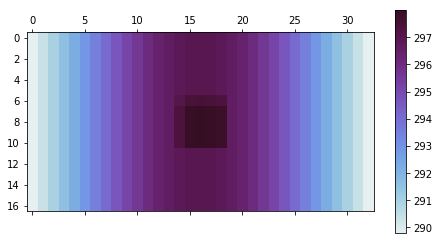

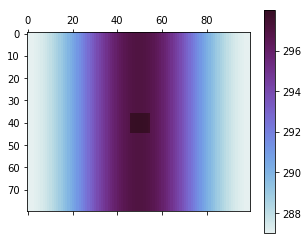

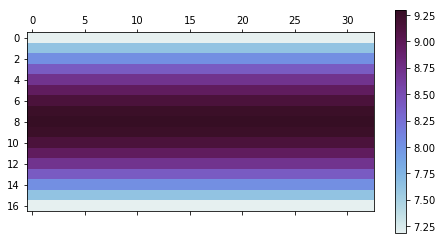

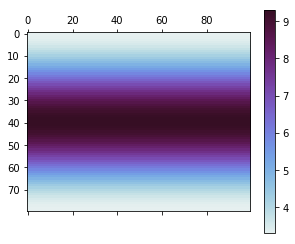

In [18]:
# first, set up the retrieval grid, which is independent from fwd model and
#  independent from the background (lat/lon/alt) grid if chosen

utx, uty = 1.6, 0.8      # grid defined radially out from center, so these are half-widths
r_lims = [lat0-uty, lat0+uty, lon0-utx, lon0+utx] # lat/lon limits  (box in middle of overall box)
#r_resa  = resa*1.5         # tied to a factor of lat/lon grid resolution,
#r_reso  = reso*1.5         #  but not (necessarily) exact same points as lat/lon grid 

r_lon  = np.arange(r_lims[2], r_lims[3]+r_reso, r_reso)
r_lat  = np.arange(r_lims[0], r_lims[1]+r_resa, r_resa)

print('retrieval grid resolution: ', r_resa, r_reso)
#print('retrieval lon grid: ', r_lon)
#print('retrieval lat grid: ', r_lat)

# create grids of retrieval lats/lons for calculations of distance and plotting below
ri, rj = np.meshgrid(r_lat, r_lon, indexing='ij')  
print(ri.shape,rj.shape)
# and the same for original ARTS background grid
gi, gj = np.meshgrid(ws.lat_grid, ws.lon_grid, indexing='ij')
print(gi.shape,gj.shape)

# calculate 'x_truth' which is mapping s_data to the retrieval grid
x_truth = np.zeros([nrvar, r_lat.size, r_lon.size])
print('rgrid dimensions: ',x_truth.shape)
from scipy.interpolate import interp2d 
f = interp2d(ws.lon_grid, ws.lat_grid, s_data[0,:,:]) #, kind='cubic')
x_truth[0,:,:] = f(r_lon,r_lat)
if nrvar>1:
    f = interp2d(ws.lon_grid, ws.lat_grid, s_data[1,:,:]) #, kind='cubic')
    x_truth[1,:,:] = f(r_lon,r_lat)

for r in range(nrvar):
    plt.matshow(x_truth[r,:,:], cmap=cmo.dense)
    plt.colorbar()
    plt.matshow(s_data[r,:,:], cmap=cmo.dense)
    plt.colorbar()


In [19]:
## map x_truth to background grid in ARTS, check it looks right
#ws.x = np.concatenate([bla.flatten(order = "f") for bla in x_truth])
#print(ws.x.value)
#ws.x2artsAtmAndSurf()
#plt.figure(figsize=[14,7])
#plt.pcolor(ws.surface_props_data.value[0,:,:])
#plt.colorbar()
#plt.show()

# Set prior and covariance matrices

Xa shape:  (2, 17, 33)
Se cov shape:  (8330, 8330)


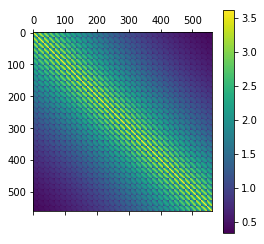

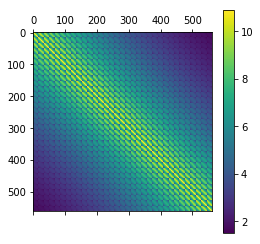

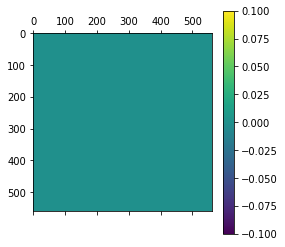

In [20]:

# set Xa (formally set in ARTS below)
xa = np.zeros([nrvar, r_lat.size, r_lon.size]) # a priori matrix, should be similar to s_data
print('Xa shape: ', xa.shape)
xa[0,:,:] = np.mean(x_truth[0,:,:]) #+np.random.normal(0,1,[r_lat.size,r_lon.size]) #+ 0.07  # set constant, or maybe some perturbation
if nrvar>1:
    xa[1,:,:] = np.mean(x_truth[1,:,:]) #+np.random.normal(0,1,[r_lat.size,r_lon.size])

# then observation errors (first just sensor noise)
se_cov = np.diag(np.tile(np.repeat(nedt**2,2), npix*nscans ))  # if nedt constant for all chans
print('Se cov shape: ', se_cov.shape) # square matrix of side length npix*nscans*nf*2

# calculate distances between points on retrieval grid for distance-dependent correlations in sx_cov
#dists = squareform( pdist( np.array([ri.flatten(), rj.flatten()]).transpose() )) 
dists = squareform( pdist( np.array([ri.flatten(order="F"), rj.flatten(order="F")]).transpose() )) 
# ri/rj flattened in F order because all 2D arrays interpreted in 1D by arts get reshaped internally!

# can try making decorrelation lengths gradient-dependent (wait for a non-flat prior for testing!):
#rygrad, rxgrad = np.gradient(xa[:,:,0])
#pseudo_grad = 0.5 * (np.abs(rygrad)*r_resa + np.abs(rxgrad)*r_reso)   # should be array of xa size
## abs values, add gradients in x and y by retr grid resolution
#deco_grid = np.ones_like(dists)*deco
#deco_grid[pseudo_grad > 0] *= np.exp(-1.0*pseudo_grad[pseudo_grad>0])  
## ad hoc, weight decorr length to be shorter if there's a non-zero gradient in apriori 


# then a priori state errors (Sa or Sx)
len_rgrid = r_lat.size*r_lon.size # total number of points in retrieval grid
nsx = np.sum(range(nrvar+1)) # 'triangle number' determines # of matrix blocks that define sx_cov

# blocks of larger, sparse Sa unless the off-off diagonal elements are filled in (SST/wsp covariances)
sx_cov = np.zeros([len_rgrid,len_rgrid, nsx], order="C")

# common for both:
sx_cov[:,:,0] = np.diag( np.tile(sx_sst**2, len_rgrid)) 
corrs_sst = np.exp(-dists/deco_sst) 
for x in range(len_rgrid):
    for y in range(len_rgrid):
        sx_cov[x,y,0]  = sx_sst * sx_sst * corrs_sst[x,y]  # i.e.  cov = r * sig * sig
    
if nrvar==2:  # wind and cross-correlations
    corrs_wsp = np.exp(-dists/deco_wsp)
    sx_cov[:,:,1] = np.diag( np.tile(sx_wsp**2, len_rgrid)) 
    for x in range(len_rgrid):
        for y in range(len_rgrid):
            sx_cov[x,y,1]  = sx_wsp * sx_wsp * corrs_wsp[x,y]  # if sx_wsp is function of loc, include here
            # cross correlations! (w/ spatial corr from 1):
            sx_cov[x,y,2]  = sx_wsp * sx_sst * corrs_wsp[x,y] * xcorr  # cross correlations


for rv in range(nsx):   # can plot each a priori covariance matrix block:
    plt.matshow(sx_cov[:,:,rv])
    plt.colorbar()
    plt.show()


# Finalize retrieval setup in ARTS, run yCalc for syn. observation vector

In [21]:
# formally set covarainces and prior for ARTS OEM:
#  [use numpy copy to make damn sure arrays are separate in memory]

ws.retrievalDefInit()  # initialize then add variables

for r in range(nrvar):
    ws.retrievalAddSurfaceQuantity( g1=r_lat, g2=r_lon, quantity=s_names[r])
    ws.covmat_sxAddBlock(block = np.copy(np.squeeze(sx_cov[:,:,r])), i=r, j=r )  # for 'diagonal' blocks
    
# for cross-correlation blocks (if more than 2 vars, revisit this):
#if nrvar>1:
#    ws.covmat_sxAddBlock(block = np.copy(np.squeeze(sx_cov[:,:,2])), i=0, j=r )

xa_forarts = np.concatenate([bla.flatten(order="F") for bla in xa])  # ordering bullshit
#xa_forarts = xa.flatten()
ws.Copy(ws.xa, np.copy(xa_forarts))  # copy python xa to arts xa (everything collapsed to 1D)
#ws.Print(ws.xa, 0) # Print Xa to terminal

ws.covmat_seSet(np.copy(se_cov))

ws.retrievalDefClose()



In [22]:
# first forward model call, to calculate synthetic observation vector
ws.yCalc() 
initial_tb = np.copy(ws.y.value)  # copy into python memory
#print(np.shape(initial_tb))


# define first guess for x in iteration. if no ws.x is set before OEM runs, it uses ws.xa.
#### flatten x_truth / xa / whatever in correct order for ARTS
#firstg = np.concatenate([bla.flatten(order = "f") for bla in x_truth])
firstg = np.concatenate([bla.flatten(order = "f") for bla in xa])
#firstg = x_truth.flatten()
ws.x = firstg
#ws.x = ws.xa #firstg

#firstg = np.copy((x_truth +np.random.normal(0,.2,x_truth.shape)).flatten()) # set first guess for ARTS OEM

In [23]:
#struth = np.concatenate([bla.flatten(order = "f") for bla in x_truth])
#firstg = np.concatenate([bla.flatten(order = "f") for bla in xa])
#ws.x = firstg
#print(ws.x.value)
#print(x_truth)
#print(struth)


In [24]:
#jqs = ws.jacobian_quantities.value
#rq =  jqs[0]
#rq.grids

In [25]:
#sst_x = firstg[:12].reshape(4, 3, order = "f")
#plt.matshow(sst_x)
#plt.colorbar()

In [26]:
###ws.x = firstg
#ws.x2artsAtmAndSurf()
#surface_props = ws.surface_props_data.value
#cz_sst = surface_props[0, :, :]
#cz_wsp = surface_props[1, :, :]
#### verify that x_truth looks correct on the big grid (within ARTS vars)
#plt.matshow(cz_sst)
#plt.colorbar()
#plt.matshow(s_data[0,:,:])
#plt.colorbar()
#plt.matshow(cz_wsp)
#plt.colorbar()
#plt.matshow(s_data[1,:,:])
#plt.colorbar()
#plt.show()

In [27]:
## map x_truth to background grid in ARTS, check it looks right
#ws.x = np.concatenate([bla.flatten(order = "f") for bla in x_truth])
##print(ws.x.value)
#ws.x2artsAtmAndSurf()
#plt.figure(figsize=[14,7])
#plt.pcolor(ws.surface_props_data.value[0,:,:])
#plt.colorbar()
#plt.figure(figsize=[14,7])
#plt.pcolor(ws.surface_props_data.value[1,:,:])
#plt.colorbar()
#plt.show()
##staaap

# Define the iteration agenda for ARTS

In [28]:
# include 'clip' limits for retrieved variables
from IPython.display import display, clear_output
ic = 0
#draw_fun = fig.canvas.draw
plt.ion()
#f, axs = plt.subplots(1, 2)
#ax_sst, ax_w = axs
#f.show()
#
#def update():
#    f.canvas.draw()
ceems = cmo.solar
ceemb = cmo.balance
#x_iter = np.zeros_like(x_truth)

@arts_agenda
def inversion_iterate_agenda(ws):
    ws.Ignore(ws.inversion_iteration_counter) # on simon's advice
    
    ws.xClip(ijq = 0, limit_low = 272.0, limit_high = 310.0)  #limits retrieval range of SST
    if nrvar>1: ws.xClip(ijq = 1, limit_low = 0.5, limit_high = 20.0)  # limits wind_speed range
        
    ws.x2artsAtmAndSurf()  # map x to ARTS's variables -- THIS INVOLVES ARTS RESHAPE OF 1D to 3D FIELDS!
    
    x_iter = np.copy( ws.x.value ).reshape(nrvar, r_lat.size, r_lon.size) 
    xb_iter = np.copy( ws.surface_props_data.value ).reshape(4, nala, nalo) # on arts background grid
    #x_iter[0,:,:] = np.copy(ws.x.value[0:r_lon.size*r_lat.size]).reshape(r_lat.size, r_lon.size, order="F") 
    #if nrvar>1:
    #    x_iter[1,:,:] = np.copy(ws.x.value[r_lon.size*r_lat.size:]).reshape(r_lat.size, r_lon.size, order="F") 
    
    ws.yCalc() 

    ws.Copy(ws.y_baseline, np.zeros([initial_tb.size])) # kinda silly but necessary?
    ws.VectorAddVector( ws.yf, ws.y, ws.y_baseline )  # add baseline term (need to create ws.yf)
    
    # this takes care of some fixes needed to get the jacobian right for iterative solutions:
    ws.jacobianAdjustAndTransform()
    
    #
    # Debug stuff: view fields as iteration progresses (will show up below OEM call)
    
    if np.mod(ic,2)==0:
        f, (ax_sst, ax_w) = plt.subplots(1, 2, figsize=[15,7])
        #n = ws.x.value.size
        #sst = ws.x.value[: n // 2]
        #w = ws.x.value[n // 2 :]
        #display(ic, sst, w)  #outputs iteration count, x vectors to screen
    
        ax_sst.set_title('SST, Iter='+str(ic//2))
        ax_w.set_title('Wind, Iter='+str(ic//2))
    
        #ax_sst.matshow(x_iter[0,:,:], vmin=np.min(s_data[0,:,:])-2, vmax=np.max(s_data[0,:,:])+2, cmap=ceems)
        #ax_w.matshow(x_iter[1,:,:], vmin=np.min(s_data[1,:,:])-2, vmax=np.max(s_data[1,:,:])+2, cmap=ceems)
        #sms = plt.cm.ScalarMappable(cmap=ceems, norm= plt.Normalize(vmin=np.min(s_data[0,:,:])-2,
        #                                                            vmax=np.max(s_data[0,:,:])+2))
        #smw = plt.cm.ScalarMappable(cmap=ceems, norm= plt.Normalize(vmin=np.min(s_data[1,:,:])-2,
        #                                                            vmax=np.max(s_data[1,:,:])+2))
        vch = 2 # cbar change value (both sst/wsp)
        #ax_sst.matshow(x_iter[0,:,:]-x_truth[0,:,:], vmin=-vch, vmax=vch, cmap=ceemb)
        ax_sst.matshow(xb_iter[0,:,:]-s_data[0,:,:], vmin=-vch, vmax=vch, cmap=ceemb)
        sms = plt.cm.ScalarMappable(cmap=ceemb, norm= plt.Normalize(vmin=-vch,vmax=vch))
        sms._A = []
        cbs = plt.colorbar(sms, ax=ax_sst)
        if nrvar>1:
            ax_w.matshow(xb_iter[1,:,:]-s_data[1,:,:], vmin=-vch, vmax=vch, cmap=ceemb)
            smw = plt.cm.ScalarMappable(cmap=ceemb, norm= plt.Normalize(vmin=-vch,vmax=vch))
            smw._A = []
            cbw = plt.colorbar(smw, ax=ax_w)
    
        clear_output(wait=True)
        display(f)  # outputs figure with x vectors to screen
        #display('grid vars updating (unreshaped): ',ws.x.value) #x_iter[1,:,:])
        #display('truth (flat): ', x_truth.flatten() )#struth)
    
    ic += 1

ws.Copy(ws.inversion_iterate_agenda, inversion_iterate_agenda)

# Perturb synthetic measurement, call OEM

In [29]:
# before calling OEM, modify (synthetic) observation vector by adding noise and/or bias offsets:

# add random gaussian noise to y -- mean, std, # of random samples
for c in range(nf):   #for chan-specific sensor noise -- assumes V/H-pol have same noise 
    initial_tb[2*c::nf*2]   += np.random.normal(0, nfac*nedt[c], initial_tb[::nf*2].size)   #bias=0,
    initial_tb[2*c+1::nf*2] += np.random.normal(0, nfac*nedt[c], initial_tb[::nf*2].size)   #gaussian noise
ws.Copy(ws.y, initial_tb)  # copy to the ARTS y vector prior to running OEM

if np.diagonal(se_cov).size != initial_tb.size:
    print('Se covariance matrix and Tb vector not same size!')
    aaaaandstop

print('last gasp')

last gasp


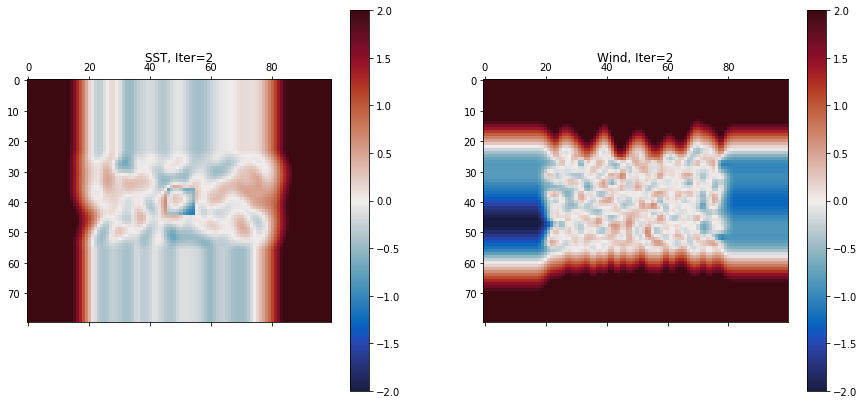

ARTS[94442698196064]:     3        1.00635      0.0292748       0.977077        0.24192
ARTS[94442698196064]: --------------------------------------------------------------------------------
ARTS[94442698196064]: 
ARTS[94442698196064]: Total number of steps:            3
ARTS[94442698196064]: Final scaled cost function value: 1.00635
ARTS[94442698196064]: OEM computation converged.
ARTS[94442698196064]: 
ARTS[94442698196064]: Elapsed Time for Retrieval:                       118.219
ARTS[94442698196064]: Time in inversion_iterate Agenda (No Jacobian):   61.507
ARTS[94442698196064]: Time in inversion_iterate Agenda (With Jacobian): 53.9002
ARTS[94442698196064]: 
ARTS[94442698196064]:                                       ----                                      
ARTS[94442698196064]: 

Completion time [s]: 279.23246145248413


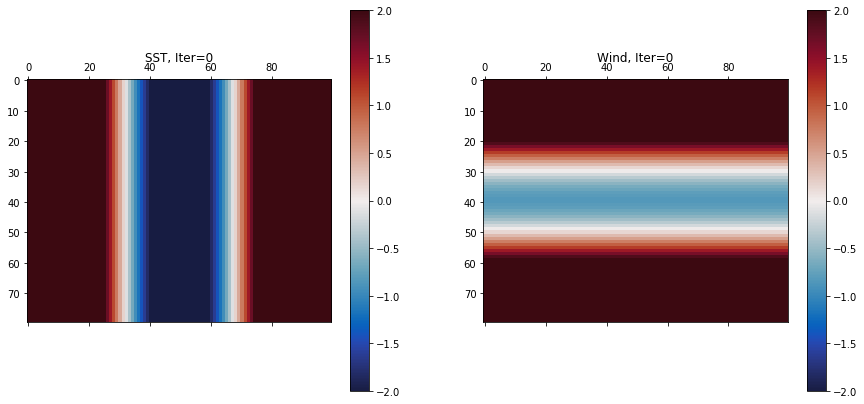

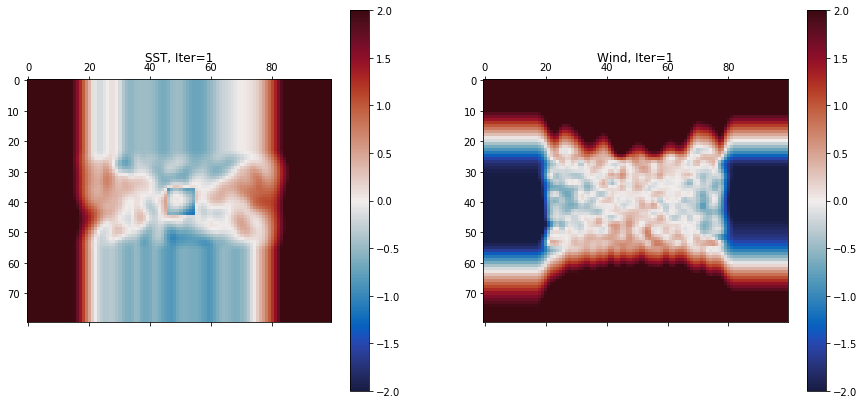

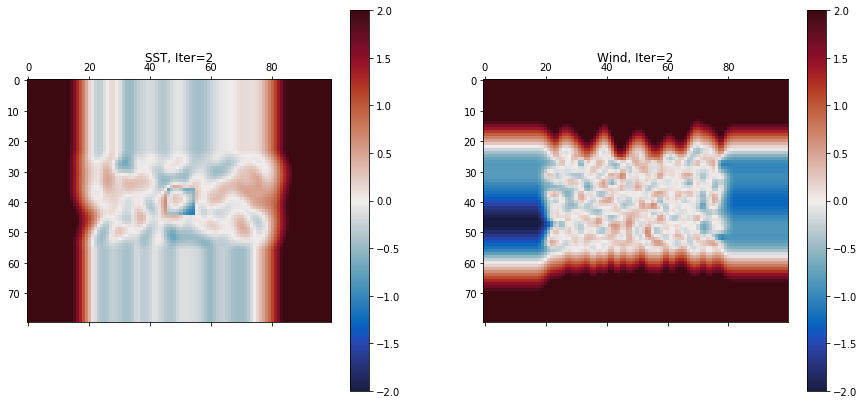

In [30]:
# Call OEM:

#  note: LM is better for non-linear problems and sfc retrieval should be very linear, so stick with GN/GN_CG
ws.OEM(method="gn",  # in one test LM took ~3x longer than GN!!
    max_iter=5,
    display_progress=1,
    max_start_cost=1e5,
    stop_dx=.4, # default is .01? -- this is to limit iterations, can dial back later for more exactness
    lm_ga_settings=np.array([10.0,2.0,3.0,10000000000.0,1.0,1.0])) # only applicable if method='lm'

ws.Print(ws.oem_errors, 0)  # print any errors to terminal

endt = time. time()
print('Completion time [s]:',endt - startt)

In [31]:
# calculate averaging kernel (A matrix) and a posteriori 
ws.avkCalc()
Amat = ws.avk.value
# A matrix should be [x,x] where x is each retrieved var. Trace(A) yields DOF for signal.
#print('Trace of A Matrix: ', np.trace(Amat))
#print('(out of possible points and vars:',np.diagonal(Amat).size)
#print('  ...so DOF per retr grid point: ',np.trace(Amat)/np.diagonal(Amat).size)
#print(np.diagonal(Amat))
ws.covmat_soCalc()
post = ws.covmat_so.value  # posterior error covariance matrix
# should be [x,x], providing uncertainties of each retrieved var, where x=npix*nscans*nretvar
 
#   retrievalErrorsExtract(retrieval_eo, retrieval_ss, covmat_so, covmat_ss )  ## ARTS method
  

In [32]:

print(shinfo(post))
ws.covmat_ssCalc()
posts = ws.covmat_ss.value  # posterior error covariance matrix
print(shinfo(posts))

['-3.99E-2', '2.30E-1', '2.09E-4', '4.51E-3', (1122, 1122)]
['-1.20E+0', '1.57E+0', '1.22E-5', '1.56E-2', (1122, 1122)]


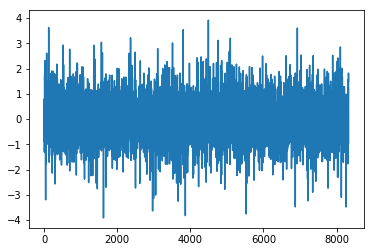

In [33]:
plt.plot(ws.y.value - ws.yf.value)

In [34]:
#print(firstg.flatten())
#print(x_truth.flatten())
#print(ws.x.value)
#print(ws.xa.value)

# Map variables back to scan/pixel arrays

(8330,)
14 35 17
(17, 35, 14)


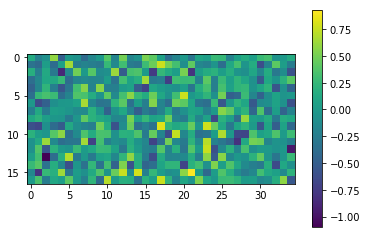

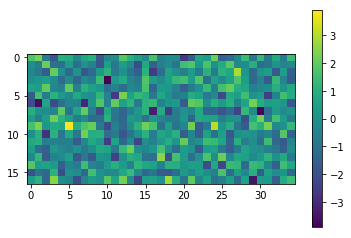

In [35]:
# yf is y_fit whereas y itself is the measurement vector here, so obs-sim is y-yf:
ydif = np.copy( ws.y.value - ws.yf.value )
ysim = np.copy( ws.yf.value)

xretr = np.zeros_like(x_truth)
xretr[0,:,:] = np.copy(ws.x.value[:r_lat.size*r_lon.size].reshape(r_lat.size,r_lon.size,order="F"))
if nrvar>1:
    xretr[1,:,:] = np.copy(ws.x.value[r_lat.size*r_lon.size:].reshape(r_lat.size,r_lon.size,order="F"))
#xretr = np.copy( ws.x.value ).reshape(nrvar, r_lat.size, r_lon.size)  

#Amat_re = np.copy( np.diagonal(Amat) ).reshape(nrvar, r_lat.size, r_lon.size)
xdif = xretr - x_truth    # save retr vs truth on rgrid
xdif_a = xretr - xa       # save difference of apriori vs retrieved

geo = np.copy(ws.y_geo.value) #columns are altitude, lat, lon, zenith, azimuth of measurement geoposition
print(np.shape(ws.y.value))
# y vector should be of size [nf*2 (stokes dim 2) ] * npix*nscans  

# vars coming out of yCalc should be in order, nch then npix then nscans, i.e.:
## with nch=6 first 6 values are from pix1,sc1 then next 6 are pix2,sc1 and so on -- be careful!
# can compare geo[:,3] (az) to EIA from L1R (later), just 180-az to get EIA


# convert vectors back to scan/pixel matrices:
sim_tb = np.zeros([nscans,npix,nf*2])
dif_tb = np.zeros([nscans,npix,nf*2]) 
arts_pos = np.zeros([nscans,npix,4]) 
print(nf*2,npix,nscans)

for c in range(nf*2):
    sim_tb[:,:,c] = ysim[c::nf*2].reshape(nscans,npix)
    dif_tb[:,:,c] = ydif[c::nf*2].reshape(nscans,npix)
    for bb in range(4):
        arts_pos[:,:,bb] = geo[c::nf*2,bb+1].reshape(nscans,npix) 
        ## arts obs points -- can differ slightly from prescribed, defined where max response is registered!
        
    
print(np.shape(dif_tb))
plt.imshow(dif_tb[:,:,0]) # 6V obs-sim
plt.colorbar()
plt.show()
plt.imshow(dif_tb[:,:,nf*2-1]) # last _H obs-sim
plt.colorbar()
plt.show()


# Plot results

In [36]:
# plotting representative ellipses:
from matplotlib.patches import Ellipse
from cartopy import crs as ccrs
from cmocean import cm as cmo
# first define widths/heights of ellipses that represent HPBW FOV for each freq:
widths  = np.array([35., 35., 24., 14., 15.,  7., 3.])[fsub] # in km across
heights = np.array([62., 62., 42., 22., 26., 12., 5.])[fsub] #  per freq, 6/7/10/18/23/36/89
if los0[0] != 132.5:
    print('ELLIPSE SIZES INCORRECT DUE TO non-AMSR sensor angle')

# convert (roughly!) to deg near equator... okay as first approximation for plotting...
#  if plotting near poles then will need to be more rigorous.
widths *= 360.0/40075. / np.abs(np.cos(np.mean(ri))) # scale widths by cos(lat)
print(widths)
heights*= 360.0/40075. # deg/circumference


#print('VERIFY THAT THESE ARE WHOLLY EVEN ON THE GRID!')
#print(np.diff(arts_pos[0,:,1]))
#print(np.diff(arts_pos[:,0,0]))

projj = ccrs.PlateCarree()
inn =  0.6
reg = [np.min(la_grid)+inn, np.max(la_grid)-inn,
           np.min(lo_grid)+inn, np.max(lo_grid)-inn]


[0.31758875 0.31758875 0.21777514 0.1270355  0.13610946 0.06351775
 0.02722189]


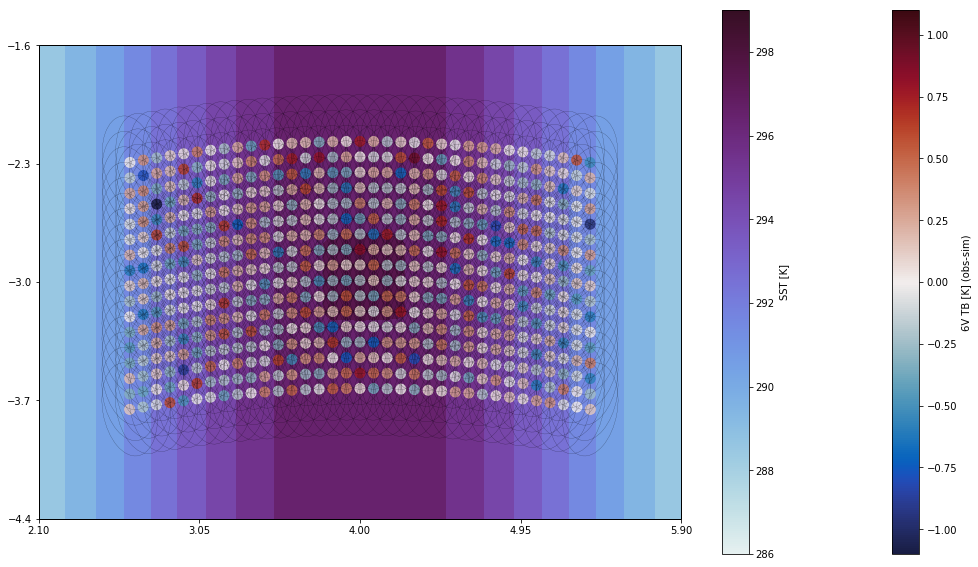

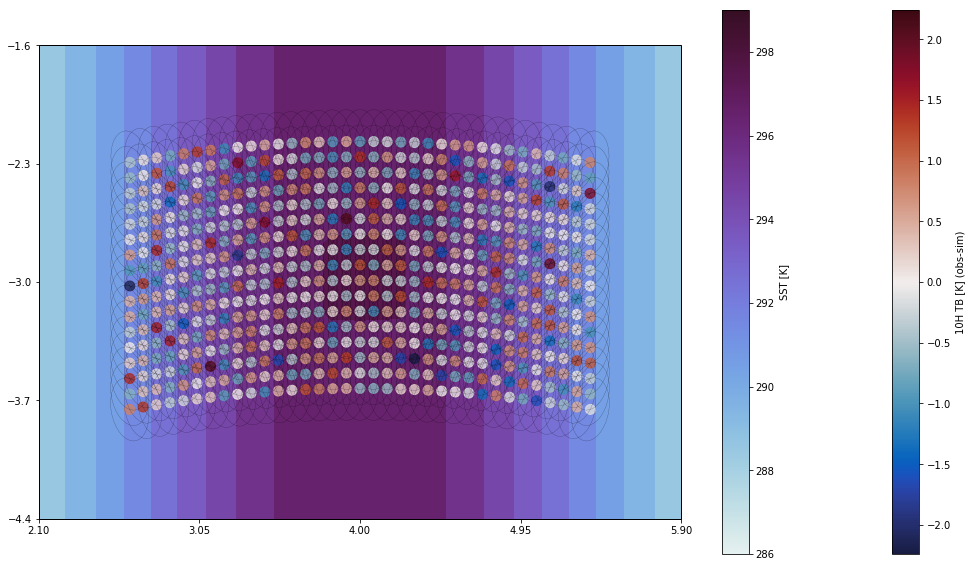

In [37]:

ks = [0,5]#,nf*2-1] # channel indices to plot

for k in ks:
    # provide x,y coords, width, height, angle of each FOV-- make an ellipse
    ells = [Ellipse(xy=[arts_pos[i,j,1],arts_pos[i,j,0]], width=widths[int(k/2)], height=heights[int(k/2)], 
                    angle=-arts_pos[i,j,3], linewidth=0.2, alpha=0.7, fill=False) 
            for i in range(nscans) for j in range(npix)]# for k in [0]] #range(nf*2)]

    fig = plt.figure(figsize=[18,10])
    ax = plt.subplot(111, projection=projj )

    ax.set_xlim(left=reg[2], right=reg[3])
    ax.set_ylim(bottom=reg[0], top=reg[1])
    nx,ny = 5,5
    ax.set_xticks( np.linspace(reg[2],reg[3], nx) )
    ax.set_yticks( np.linspace(reg[0],reg[1], ny) )

    #sdif = np.max(np.abs(tmean-s_data[0,:,:])) # set colorbar limits by largest abs deviation from tmean?
    thenorm1=plt.Normalize(vmin = np.min(s_data[0,:,:])-1, vmax = np.max(s_data[0,:,:])+1)
    ceem1=cmo.dense
    #bb= ax.pcolormesh(lon_grid,lat_grid,s_data[0,:,:],norm=thenorm1, # so SST
    bb= ax.contourf(ws.lon_grid,ws.lat_grid,s_data[0,:,:], 10, norm=thenorm1, # so SST
                 transform=projj, cmap=ceem1)

    for e in ells[:]: 
        ax.add_artist(e)

    vmin, vmax = -np.max(np.abs(dif_tb[:,:,k])), np.max(np.abs(dif_tb[:,:,k]))
    thenorm = plt.Normalize(vmin=vmin,vmax=vmax)
    ceem = cmo.balance #thermal
    ax.scatter( arts_pos[:,:,1], arts_pos[:,:,0], s=100.0, c=dif_tb[:,:,k], marker='o', \
                transform=projj, alpha=0.8, cmap=ceem, norm=thenorm);
    sm = plt.cm.ScalarMappable(cmap=ceem, norm=thenorm)
    sm._A = []
    cb = plt.colorbar(sm,ax=ax)
    cb.set_label(ch_str[k]+' TB [K] (obs-sim)')
    sm1 = plt.cm.ScalarMappable(cmap=ceem1, norm=thenorm1)
    sm1._A = []
    cb1 = plt.colorbar(sm1,ax=ax)
    cb1.set_label('SST [K]')

    if sv: plt.savefig('img2/retr-y_syn_'+ch_str[k]+'_'+pv+'.png',bbox_inches='tight',dpi=350)
    plt.show()




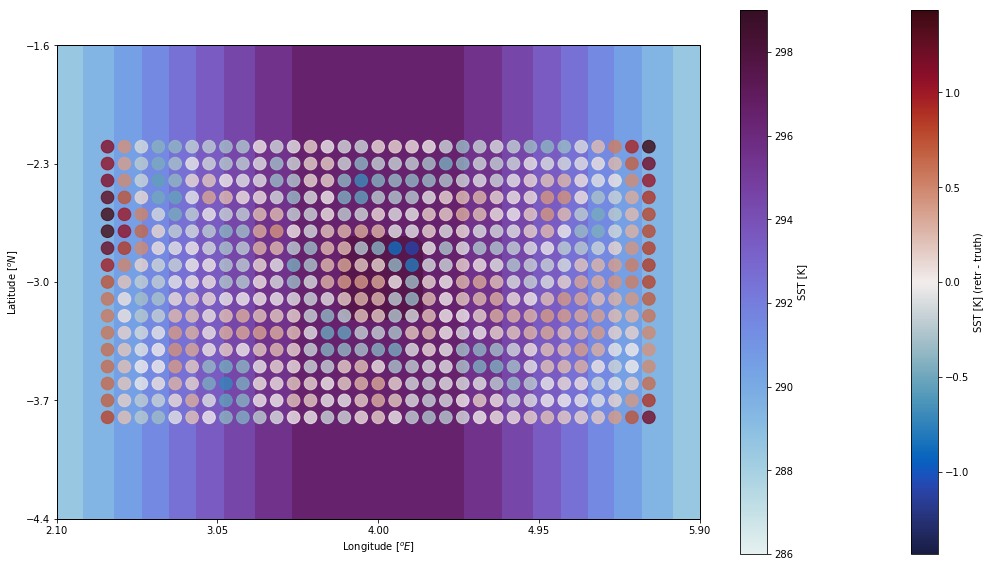

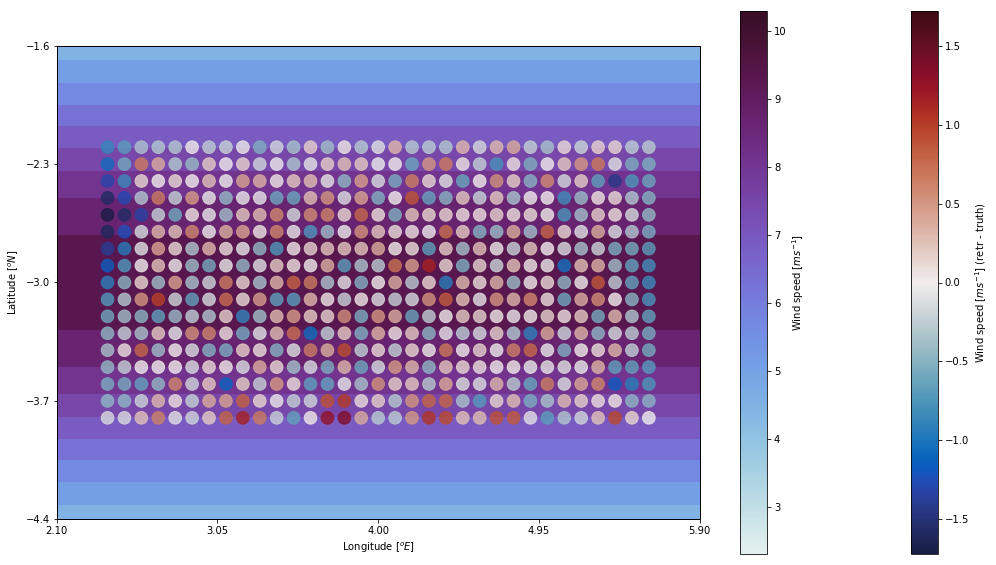

In [38]:

# and for the state vector, retrieved vs. a priori laid over background (truth):
pvar = xdif # choose what to  plot here

for rv in range(nrvar): 
    if rv==0: tit='SST [K]'
    if rv==1: tit='Wind speed [$m s^{-1}$]'
    fig2 = plt.figure(figsize=[18,10])
    ax2 = plt.subplot(111, projection=projj )

    ax2.set_xlim(left=reg[2], right=reg[3])
    ax2.set_ylim(bottom=reg[0], top=reg[1])
    ax2.set_xticks( np.linspace(reg[2],reg[3], nx) )
    ax2.set_yticks( np.linspace(reg[0],reg[1], ny) )
    ax2.set_ylabel( 'Latitude [$^o N$]' )
    ax2.set_xlabel( 'Longitude [$^o E$]' )

    thenorm1=plt.Normalize(vmin = np.min(s_data[rv,:,:])-1, vmax = np.max(s_data[rv,:,:])+1)
    #bb= ax2.pcolormesh(lon_grid,lat_grid,s_data[0,:,:],norm=thenorm1, 
    bb= ax2.contourf(ws.lon_grid,ws.lat_grid,s_data[rv,:,:], 10, norm=thenorm1, 
                 transform=projj, cmap=ceem1)

    #for e in ells[:]: 
    #    ax2.add_artist(e)

    vmin, vmax = -np.max(np.abs(pvar[rv,:,:])), np.max(np.abs(pvar[rv,:,:]))
    thenorm = plt.Normalize(vmin=vmin,vmax=vmax)
    ceem = cmo.balance #thermal
    # ri,rj defined earlier via meshgrid, i.e. retrieval lon and lat grids respectively
    ax2.scatter( rj, ri, s=160.0, c=pvar[rv,:,:], marker='o', \
                transform=projj, alpha=0.8, cmap=ceem, norm=thenorm);
    sm = plt.cm.ScalarMappable(cmap=ceem, norm=thenorm)
    sm._A = []
    cb = plt.colorbar(sm,ax=ax2)
    cb.set_label(tit+' (retr - truth)') #prior)')
    sm1 = plt.cm.ScalarMappable(cmap=ceem1, norm=thenorm1)
    sm1._A = []
    cb1 = plt.colorbar(sm1,ax=ax2)
    cb1.set_label(tit)

    if sv: plt.savefig('img2/retr-x_syn_rv'+str(rv)+'_'+pv+'.png',bbox_inches='tight',dpi=350)
    plt.show()

(80, 100) (4, 80, 100)


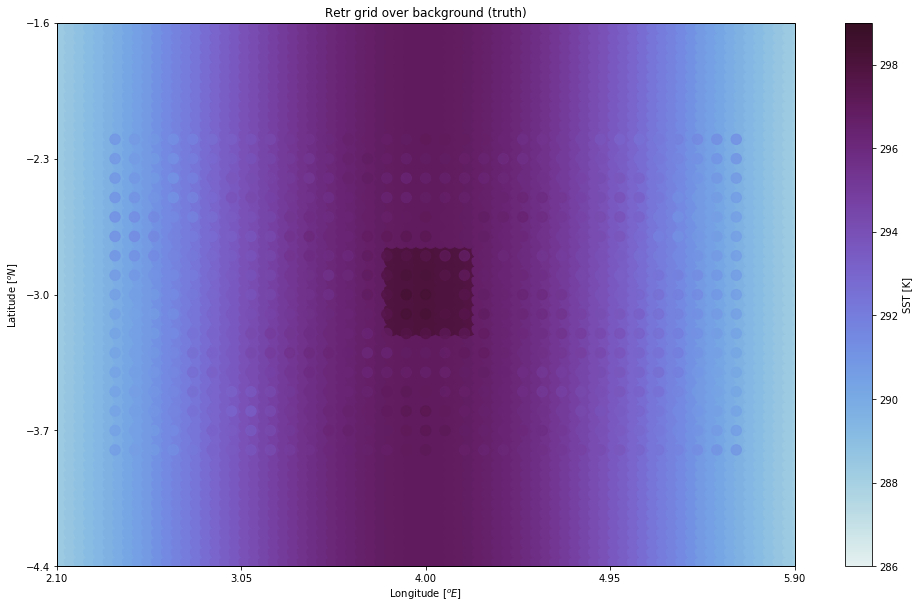

(80, 100) (4, 80, 100)


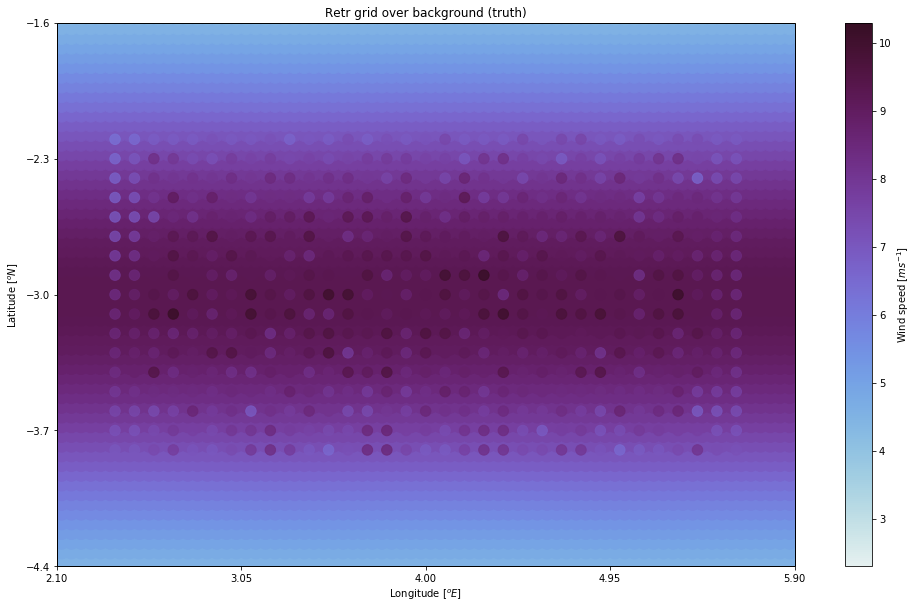

In [39]:
# SANITY CHECK: plot background (synthetic defined) state vs. x_truth on retrieval grid. 
#    should be simply interpolated values!

# and for the state vector, retrieved vs. a priori laid over background (truth):
projj = ccrs.PlateCarree()
inn =  0.6
nx,ny = 5,5
for rv in range(nrvar): 
    if rv==0: tit='SST [K]'
    if rv==1: tit='Wind speed [$m s^{-1}$]'
    fig2 = plt.figure(figsize=[18,10])
    ax2 = plt.subplot(111, projection=projj )

    ax2.set_xlim(left=reg[2], right=reg[3])
    ax2.set_ylim(bottom=reg[0], top=reg[1])
    ax2.set_xticks( np.linspace(reg[2],reg[3], nx) )
    ax2.set_yticks( np.linspace(reg[0],reg[1], ny) )
    ax2.set_ylabel( 'Latitude [$^o N$]' )
    ax2.set_xlabel( 'Longitude [$^o E$]' )

    thenorm1=plt.Normalize(vmin = np.min(s_data[rv,:,:])-1, vmax = np.max(s_data[rv,:,:])+1)
    #bb= ax2.pcolormesh(lon_grid,lat_grid,s_data[0,:,:],norm=thenorm1, 
    #bb= ax2.contourf(ws.lon_grid,ws.lat_grid,s_data[rv,:,:], 10, norm=thenorm1, 
    print(np.shape(gi),np.shape(s_data))
    bb= ax2.scatter(gj, gi, s=200, c=s_data[rv,:,:], norm=thenorm1, 
                 transform=projj, cmap=cmo.dense)

    #for e in ells[:]: 
    #    ax2.add_artist(e)

    #xdif2 = xretr - x_truth
    #vmin, vmax = -np.max(np.abs(xdif2[rv,:,:])), np.max(np.abs(xdif2[rv,:,:]))
    #thenorm = plt.Normalize(vmin=vmin,vmax=vmax)
    ceem = cmo.dense
    # ri,rj defined earlier via meshgrid, i.e. retrieval lon and lat grids respectively
    #ax2.scatter( rj, ri, s=150.0, c=x_truth[rv,:,:], marker='o', \
    ax2.scatter( rj, ri, s=110.0, c=xretr[rv,:,:], marker='o', \
                transform=projj, alpha=0.8, cmap=ceem, norm=thenorm1);
    #sm = plt.cm.ScalarMappable(cmap=ceem, norm=thenorm1)
    #sm._A = []
    #cb = plt.colorbar(sm,ax=ax2)
    #cb.set_label(tit+' (retr - prior)')
    sm1 = plt.cm.ScalarMappable(cmap=ceem, norm=thenorm1)
    sm1._A = []
    cb1 = plt.colorbar(sm1,ax=ax2)
    cb1.set_label(tit)
    ax2.set_title("Retr grid over background (truth)")

    if sv: plt.savefig('img2/retr-x_syn_rv'+str(rv)+'_'+pv+'.png',bbox_inches='tight',dpi=350)
    plt.show()

In [40]:
stapppp # who cares (for now)

# and for the DOF, take elements from A matrix diagonal:
fig3 = plt.figure(figsize=[15,10])
ax3 = plt.subplot(111, projection=projj )

ax3.set_xlim(left=reg[2], right=reg[3])
ax3.set_ylim(bottom=reg[0], top=reg[1])
ax3.set_xticks( np.linspace(reg[2],reg[3], nx) )
ax3.set_yticks( np.linspace(reg[0],reg[1], ny) )

bb= ax3.pcolormesh(lon_grid,lat_grid,s_data[0,:,:],norm=thenorm1, # so SST
             transform=projj, cmap=ceem1)

#for e in ells[:]: 
#    ax3.add_artist(e)
    
vmin, vmax = 0, 1 #-np.max(np.abs(xdif[:,:])), np.max(np.abs(xdif[:,:]))
thenorm = plt.Normalize(vmin=vmin,vmax=vmax)
ceem = cmo.solar
# ri,rj defined earlier via meshgrid
ax3.scatter( ri, rj, s=200.0, c=Amat_re[0,:,:], marker='o',    # pick which Amat vars?
            transform=projj, alpha=0.8, cmap=ceem, norm=thenorm);
sm = plt.cm.ScalarMappable(cmap=ceem, norm=thenorm)
sm._A = []
cb = plt.colorbar(sm,ax=ax3)
cb.set_label('DOFS')
sm1 = plt.cm.ScalarMappable(cmap=ceem1, norm=thenorm1)
sm1._A = []
cb1 = plt.colorbar(sm1,ax=ax3)
cb1.set_label('SST [K]')

#plt.savefig('img2/retr-A_syn_'+pv+'.png',bbox_inches='tight',dpi=350)
plt.show()

NameError: name 'stapppp' is not defined

In [ ]:
# to run fastem alone for testing, outputting emissivities and expected TBs with no atmosphere:
#ws.MatrixCreate("emissivity")
#ws.MatrixCreate("reflectivity")
#ws.reflectivity = np.zeros([f_grid.size,4])
#ws.emissivity   = np.zeros([f_grid.size,4])
##ws.surface_skin_t = tmean #s_data[0,:,:]
##ws.transmittance
#ws.transmittance = np.ones( ws.f_grid.value.shape ) * 0.7
#yep = 34
#emii = np.zeros([yep,nf,2])
#tbout= np.zeros([yep,nf,2])
#tmean=270.0
#for y in range(yep):
#    ws.surface_skin_t = tmean+float(y) #s_data[0,:,:]
#    ws.FastemStandAlone(surface_skin_t= tmean+y, f_grid=ws.f_grid,
#                        emissivity=ws.emissivity, reflectivity=ws.reflectivity,
#                        za=125.0, wind_speed=wsp, rel_aa=0.0, transmittance=ws.transmittance.value)
#    emii[y,:,:] = ws.emissivity.value[:,0:2]
#    tbout[y,:,:]= ws.emissivity.value[:,0:2]*tmean+y

In [ ]:
#### soooo, emissivity varies quite little with temperature for 6V (0.557->.553->.56),
#     declines slightly at 18 (.64->.58), then bigtime at 89 (.84->.74)
##print(ws.emissivity.value)
#print(emii[:,0,0]) # 6
##print(emii[:,3,0]) # 18
##print(emii[:,5,0]) # 36
#print(emii[:,-1,0]) # 89
#
#print(tbout[:,1,0])
##print(tbout[:,2,0])
#print(tbout[:,-1,0])

In [ ]:
print(ws.covmat_sx.from_typhon)